## Point Registration

This tutorial shows you how to register 'nii' files with points. The points can be computed by segmentations like in Verse19.

You can get the Verse19 data from:

https://osf.io/nqjyw/

We assume in this tutorial that you copied the "dataset-verse19validation" folder next to this file.


In [1]:
from pathlib import Path
from pointreg import ridged_from_points, resample
from BIDS import Centroids, NII
from BIDS.snapshot2D import Snapshot_Frame, create_snapshot
from IPython.display import Image

loading data

In [2]:
# ct1 = Path("dataset-verse19validation/rawdata/sub-verse018/sub-verse018_ct.nii.gz")
# ct2 = Path("dataset-verse19validation/rawdata/sub-verse026/sub-verse026_ct.nii.gz")

ct1 = Path("dataset-verse19validation/rawdata/sub-verse404/sub-verse404_split-verse256_ct.nii.gz")
ct2 = Path("dataset-verse19validation/rawdata/sub-verse404/sub-verse404_split-verse209_ct.nii.gz")


# ct1 = Path("dataset-verse19validation/rawdata/sub-verse412/sub-verse412_split-verse290_ct.nii.gz")
# ct2 = Path("dataset-verse19validation/rawdata/sub-verse412/sub-verse412_split-verse235_ct.nii.gz")


def to_vert(p: Path):
    return Path(str(p).replace("rawdata", "derivatives").replace("_ct.nii.gz", "_seg-vert_msk.nii.gz"))


def to_poi(p: Path):
    return Path(str(p).replace("rawdata", "derivatives").replace("_ct.nii.gz", "_seg-vb_ctd.json"))


c1_vert = to_vert(ct1)
c2_vert = to_vert(ct2)
c1_poi = to_poi(ct1)
c2_poi = to_poi(ct2)

### From Centroid or Points of Interest(POI) list

We load the POIs form the json. It should have the following shape:
```[
    {
        "direction": ["P","I","R"]
    },
    {
        "label": 20, "X": 91.1,"Y": 40.0, "Z": 95.0
    },
    {
        "label": 21, "X": 76.5,"Y": 68.1, "Z": 90.3
    },
    {
        "label": 22, "X": 63.6,"Y": 101.2, "Z": 86.3
    },
    {
        "label": 23, "X": 59.0,"Y": 136.8, "Z": 86.8
    },
    {
        "label": 24, "X": 72.1,"Y": 166.6, "Z": 94.0
    }
]
```

where the coordinate are the local cords of the image

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
('P', 'S', 'R')
(-0.03768163190368767, 0.014190344115167113, -0.9991890355438093, 0.9988955728122845, -0.02754874534181795, -0.03806180823489409, 0.028066514445031738, 0.9995197350547836, 0.013136590231944465)
[*] used centroids: [7 8 9]
[*] key|fixed points           |moved points after     |moved points before    |delta fixed/moved      |distF|distM|
[*] 7  |   20.9, -226.6, -441.5|   20.9, -226.5, -441.5|   19.5, -233.1, -350.9|    0.0,   -0.1,   -0.0|     |     |
[*] 8  |   22.2, -219.4, -460.7|   22.3, -219.5, -460.7|   21.4, -225.0, -369.7|   -0.1,    0.1,    0.0|20.5 |20.6 |
[*] 9  |   24.4, -212.6, -482.2|   24.4, -212.5, -482.1|   24.4, -216.5, -390.4|    0.0,   -0.1,   -0.1|22.7 |22.6 |
[*] Error avg registration error-vector length:   0.128
[*] Error avg point-distances:   0.100
[ ] 'set_array' with different dtype: from float32 to uint8
[ ] 'set_array' with different dtype: from float32 to uint8
[ ] 'set_

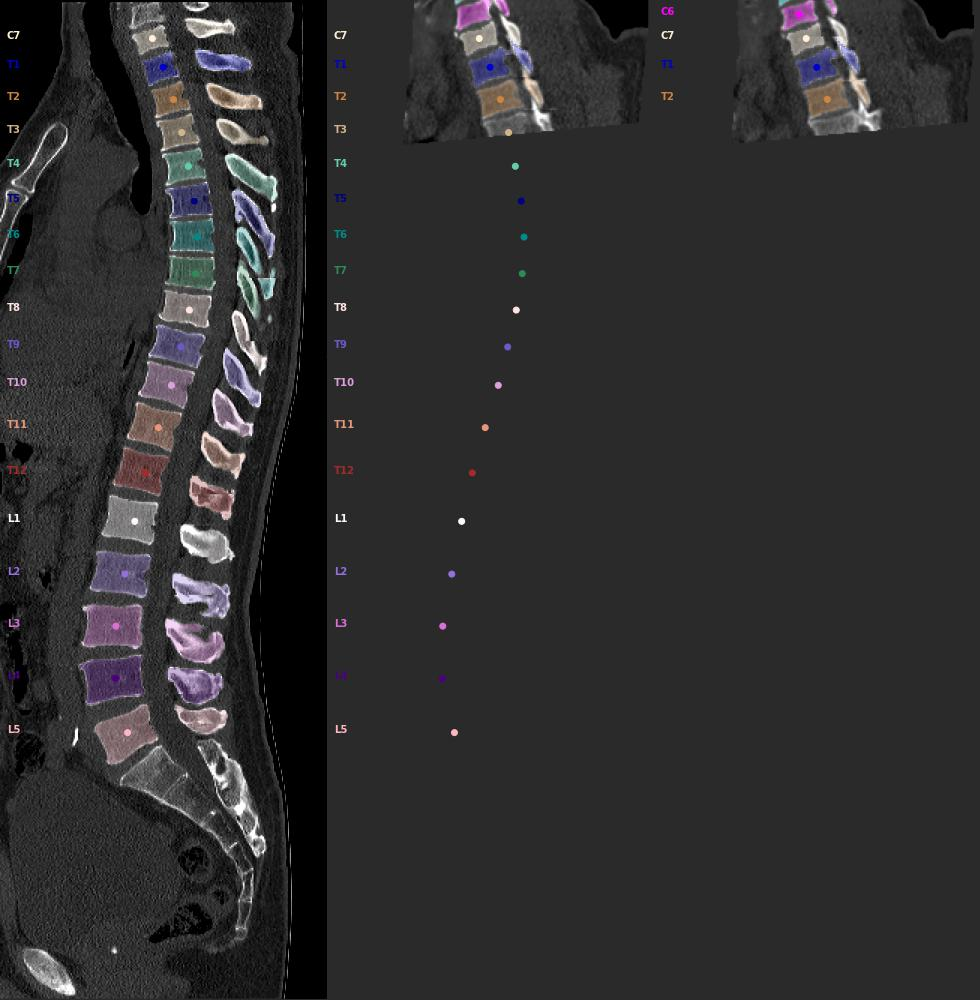

In [3]:
# Given centroid file in local space an nii we can register two images
resampler, resampler_seg, transform = ridged_from_points(
    Centroids().load(c1_poi), Centroids().load(c2_poi), representative_fixed=ct1, representative_movig=ct2
)
assert resampler is not None
assert resampler_seg is not None
assert transform is not None
rep_moving_nii: NII = resample(resampler, resampler_seg, moving_img=ct2)
rep_seg_moving_nii: NII = resample(resampler, resampler_seg, moving_img=c2_vert, is_seg=True)
ct1_frame = Snapshot_Frame(ct1, segmentation=c1_vert, centroids=c1_poi, mode="CT")
ct2_frame = Snapshot_Frame(rep_moving_nii, segmentation=rep_seg_moving_nii, centroids=c1_poi, mode="CT")

c2_poi_trans = transform.transform_points(Centroids().load(c2_poi), origins_shift2=None)
ct3_frame = Snapshot_Frame(rep_moving_nii, segmentation=rep_seg_moving_nii, centroids=c2_poi_trans, mode="CT")
create_snapshot("test.jpg", [ct1_frame, ct2_frame, ct3_frame])
Image(filename="test.jpg")

The moved images has some space unoccupied. We can remove non corresponding spaces by cropping

[ ] 'set_array' with different dtype: from float32 to uint8
index 217 is out of bounds for axis 0 with size 106
index 217 is out of bounds for axis 0 with size 106
[ ] 'set_array' with different dtype: from float32 to uint8


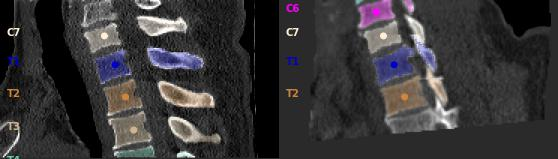

In [4]:
from BIDS import to_nii, NII

# NII is a wrapper around nibabel
ct1_nii = to_nii(ct1).copy()
ct2_nii = rep_moving_nii.copy()
ct1_seg = to_nii(c1_vert, seg=True)
ct2_seg = rep_seg_moving_nii.copy()

ex_slice_f = ct1_nii.compute_crop_slice()
shared_pixels = ct2_nii.compute_crop_slice(other_crop=ex_slice_f)


c1_poi_cropped = Centroids().load(c1_poi).shift_all_centroid_coordinates(shared_pixels)
ct1_nii.apply_crop_slice_(shared_pixels)
ct2_nii.apply_crop_slice_(shared_pixels)
ct1_seg.apply_crop_slice_(shared_pixels)
ct2_seg.apply_crop_slice_(shared_pixels)
c2_poi_trans2 = c2_poi_trans.shift_all_centroid_coordinates(shared_pixels)

ct1_frame = Snapshot_Frame(ct1_nii, segmentation=ct1_seg, centroids=c1_poi_cropped, mode="CT")
ct2_frame = Snapshot_Frame(ct2_nii, segmentation=ct2_seg, centroids=c2_poi_trans2, mode="CT")
create_snapshot("test.jpg", [ct1_frame, ct2_frame])
Image(filename="test.jpg")

## Computing Centroids from segmentation

We can generate Centroids/POI by computing the Center Of Mass of Segmentation.

Variant 1: Just using the segmentation

In [5]:
from BIDS import calc_centroids

ctd = calc_centroids(c1_vert, decimals=0)
print(to_nii(c1_vert))
print("orientation", ctd.orientation)
print("shape", ctd.shape)
print("zoom", ctd.zoom)
print("points", ctd.keys())
print("id 9", ctd[9])
print("\n", ctd)

shp=(218, 667, 86); ori=('P', 'S', 'R'), zoom=(1.0, 1.0, 1.9999613), seg=False
orientation ('P', 'S', 'R')
shape (218, 667, 86)
zoom (1.0, 1.0, 1.999961256980896)
points dict_keys([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
id 9 (127.0, 604.0, 41.0)

 Centroids(orientation=('P', 'S', 'R'), centroids={7: (112.0, 644.0, 42.0), 8: (120.0, 626.0, 41.0), 9: (127.0, 604.0, 41.0), 10: (134.0, 581.0, 39.0), 11: (139.0, 557.0, 39.0), 12: (143.0, 533.0, 39.0), 13: (145.0, 508.0, 40.0), 14: (142.0, 483.0, 41.0), 15: (138.0, 458.0, 41.0), 16: (132.0, 432.0, 41.0), 17: (126.0, 406.0, 42.0), 18: (117.0, 378.0, 42.0), 19: (108.0, 349.0, 41.0), 20: (102.0, 316.0, 40.0), 21: (95.0, 281.0, 38.0), 22: (90.0, 247.0, 37.0), 23: (89.0, 214.0, 38.0), 24: (95.0, 181.0, 41.0)}, location=<Location.Unknown: 0>, zoom=(1.0, 1.0, 1.999961256980896), info={})


Variant 2: Segmentation and Subregion Segmentation

If you have two files, where the second splits the other in smaller chunks you can use this variant. (Verse does not provide this...)

In [6]:
vert_nii = to_nii(c1_vert, seg=True)
arr = vert_nii.get_array()
arr[arr != 0] = 50
subregion_nii = vert_nii.set_array(arr, inplace=False)
from BIDS import calc_centroids_from_subreg_vert

ctd = calc_centroids_from_subreg_vert(vert_nii, subregion_nii, subreg_id=[50])
print(ctd)
print(list(ctd.items2()))
print("Note: the ids are subregion_ID*256 + segmentation id. Matching points MUST have the same ID")

[ ] 'set_array' with different dtype: from uint8 to uint16
Centroids(orientation=('P', 'S', 'R'), centroids={12807: (112.2, 643.9, 41.7), 12808: (119.8, 625.5, 41.4), 12809: (126.7, 603.8, 40.6), 12810: (134.3, 580.7, 39.4), 12811: (139.4, 557.2, 39.0), 12812: (143.2, 533.2, 39.3), 12813: (144.6, 508.0, 40.2), 12814: (142.2, 482.7, 40.9), 12815: (137.6, 457.6, 41.3), 12816: (132.1, 432.1, 41.4), 12817: (126.0, 406.3, 41.9), 12818: (116.8, 378.0, 41.7), 12819: (107.8, 348.6, 41.1), 12820: (101.8, 316.2, 40.1), 12821: (95.4, 281.0, 38.3), 12822: (90.2, 247.4, 37.4), 12823: (88.8, 214.0, 38.4), 12824: (95.0, 181.3, 41.1)}, location=<Location.Multi: 256>, zoom=(1.0, 1.0, 1.999961256980896), info={})
[(50, 7, (112.2, 643.9, 41.7)), (50, 8, (119.8, 625.5, 41.4)), (50, 9, (126.7, 603.8, 40.6)), (50, 10, (134.3, 580.7, 39.4)), (50, 11, (139.4, 557.2, 39.0)), (50, 12, (143.2, 533.2, 39.3)), (50, 13, (144.6, 508.0, 40.2)), (50, 14, (142.2, 482.7, 40.9)), (50, 15, (137.6, 457.6, 41.3)), (50, 16, 

Let's use a function that does all at once and use the Vertebra center and the mask centers.

dict_keys([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 257, 258, 259, 260, 261, 262, 263, 264, 265])
[*] Register to shp=(218, 667, 86); ori=('P', 'S', 'R'), zoom=(1.0, 1.0, 1.9999613), seg=False
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280]
('P', 'S', 'R')
(-0.03768163190368767, 0.014190344115167113, -0.9991890355438093, 0.9988955728122845, -0.02754874534181795, -0.03806180823489409, 0.028066514445031738, 0.9995197350547836, 0.013136590231944465)
[*] used centroids: [  7   8   9 263 264 265]
[*] key|fixed points           |moved points after     |moved points before    |delta fixed/moved      |distF|distM|
[*] 7  |   20.9, -226.6, -441.5|   21.1, -226.5, -441.4|   19.5, -233.1, -350.9|   -0.2,   -0.1,   -0.1|     |     |
[*]

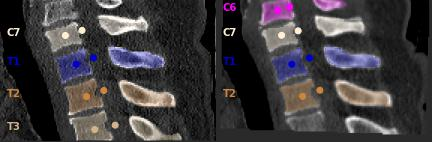

In [7]:
from pointreg import ridged_registration_cdt

poi1 = Centroids().load(to_poi(ct1))
poi1_2 = calc_centroids(to_nii(c1_vert, True))
for k, v in poi1_2.items():
    poi1[k + 256] = v
print(poi1.keys())

poi2 = Centroids().load(to_poi(ct2))
poi2_2 = calc_centroids(to_nii(c2_vert, True))
for k, v in poi2_2.items():
    poi2[k + 256] = v
print(poi2.keys())
fixed, moving, (_, _, point_trans, crop) = ridged_registration_cdt(
    ctd_fixed=poi1,
    ctd_movig=poi2,
    list_fixed=[to_nii(ct1, False), to_nii(c1_vert, True)],
    list_moving=[to_nii(ct2, False), to_nii(c2_vert, True)],
)
poi1_reg = poi1.crop_centroids(crop)
poi2_reg = point_trans.transform_points(poi2, crop)
ct1_frame = Snapshot_Frame(fixed[0], segmentation=fixed[1], centroids=poi1_reg, mode="CT")
ct2_frame = Snapshot_Frame(moving[0], segmentation=moving[1], centroids=poi2_reg, mode="CT")
create_snapshot("test.jpg", [ct1_frame, ct2_frame])
Image(filename="test.jpg")

You should see that the lower vertebras have their spinous process visible.

[ ] 'set_array' with different dtype: from float32 to uint8
index 217 is out of bounds for axis 0 with size 95
index 217 is out of bounds for axis 0 with size 95
[ ] 'set_array' with different dtype: from float32 to uint8
[ ] 'set_array' with different dtype: from float32 to uint8


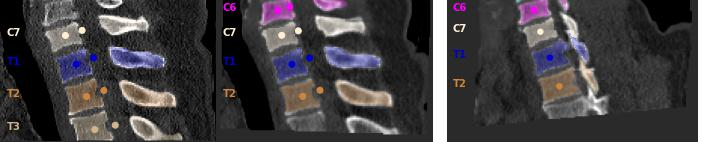

In [8]:
ct1_frame = Snapshot_Frame(
    fixed[0],
    segmentation=fixed[1],
    centroids=poi1_reg,
    mode="CT",
)
ct2_frame = Snapshot_Frame(
    moving[0],
    segmentation=moving[1],
    centroids=poi2_reg,
    mode="CT",
)

ct2_frame_single = Snapshot_Frame(ct2_nii, segmentation=ct2_seg, centroids=c2_poi_trans2, mode="CT")
create_snapshot("test.jpg", [ct1_frame, ct2_frame, ct2_frame_single])
Image(filename="test.jpg")

Locking at the coronal direction you should see that the vertebra are rotated unlike the other image

[ ] 'set_array' with different dtype: from float32 to uint8
index 217 is out of bounds for axis 0 with size 95
index 217 is out of bounds for axis 0 with size 95
[ ] 'set_array' with different dtype: from float32 to uint8
[ ] 'set_array' with different dtype: from float32 to uint8


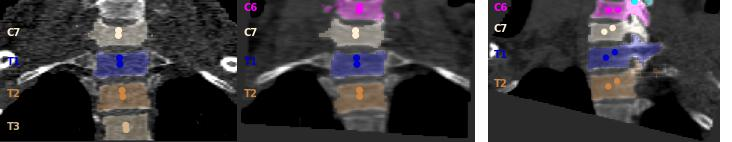

In [9]:
ct1_frame = Snapshot_Frame(fixed[0], segmentation=fixed[1], centroids=poi1_reg, mode="CT", coronal=True, sagittal=False)
ct2_frame = Snapshot_Frame(moving[0], segmentation=moving[1], centroids=poi2_reg, mode="CT", coronal=True, sagittal=False)
c2_poi_ = c2_poi_trans2
for k, v in calc_centroids(to_nii(ct2_seg, True)).items():
    c2_poi_[k + 256] = v

ct2_frame_single = Snapshot_Frame(ct2_nii, segmentation=ct2_seg, centroids=c2_poi_, mode="CT", coronal=True, sagittal=False)
create_snapshot("test.jpg", [ct1_frame, ct2_frame, ct2_frame_single])
Image(filename="test.jpg")